In [1]:
import sys

import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from batch_gen import SixNumbersBatch
from net import SixHeadedInception
sys.path.append('../..')
import utils
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST
from dataset.models.tf import Inception_v4

In [2]:
dset = MNIST(batch_class=SixNumbersBatch)

ExtractingExtractingExtractingExtracting   /tmp/t10k-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gz/tmp/train-images-idx3-ubyte.gz


 /tmp/t10k-labels-idx1-ubyte.gz


In [3]:
ppl = (Pipeline()
       .resize(shape=(128, 128))
       .normalize_images()
       .gluing_of_images())
#        .colorize_images(colors=[[0., 0., 1.], [0., 1., 0.]]))

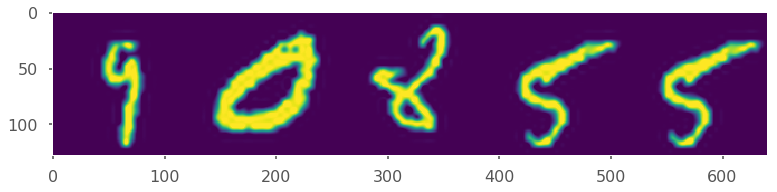

In [4]:
p = (ppl<<dset.train).next_batch(14)
plt.imshow(p.images[0].reshape(128, 640))
plt.grid()

In [5]:
inputs_config = {'images': {'shape':(128, 640, 1)},
                 'labels':{'shape':(5)},#, 'transform': 'ohe', 'name':'targets'},
                 'fir':{'classes':(10), 'transform': 'ohe', 'name':'first'},
                 's':{'classes':(10), 'transform': 'ohe', 'name':'second'},
                 't':{'classes':(10), 'transform': 'ohe', 'name':'third'},
                 'f':{'classes':(10), 'transform': 'ohe', 'name':'fourth'}, 
                 'fi':{'classes':(10), 'transform': 'ohe', 'name':'fifth'}}

config = {'inputs':inputs_config,
          'optimizer': 'Adam',
          'loss': None,
          'input_block/inputs': 'images'}

feed_dict = {'images': B('images'),
                    'labels': B('labels'),
                    'fir': B('first'),
                    's': B('second'),
                    't': B('third'),
                    'f': B('fourth'),
                    'fi': B('fifth')}

In [8]:
train_ppl = ((ppl<<dset.train)
                    .init_model('dynamic',
                                SixHeadedInception,
                                'fourinception',
                                config=config)
                   .train_model('fourinception',
                                feed_dict=feed_dict))
test_ppl = ((ppl<<dset.test)
                    .init_variable('loss', init_on_each_run=list)
                    .import_model('fourinception', train_ppl)
                    .predict_model('fourinception',
                                  fetches='loss',
                                  feed_dict=feed_dict,
                                  save_to=V('loss'), mode='a'))

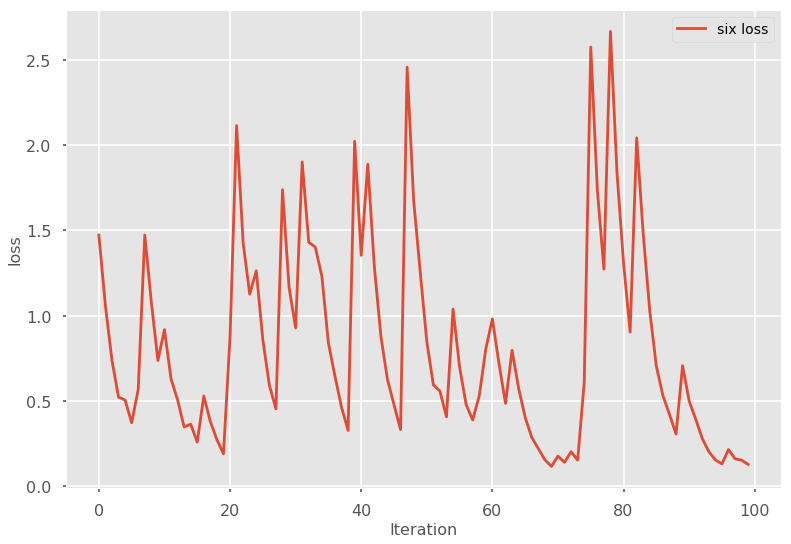

KeyboardInterrupt: 

In [9]:
for i in tqn(range(30000)):
    train_ppl.next_batch(12, n_epochs=None, suffle=True)
    test_ppl.next_batch(12, n_epochs=None, suffle=True)
    if i%10==0:
        clear_output(True)
        utils.draw(test_ppl.get_variable('loss')[-100:], 'six')
        plt.show()

In [10]:
ppl_test = ((ppl<<dset.test)
                    .init_variable('output', init_on_each_run=list)
                    .import_model('fourinception', train_ppl)
                    .predict_model('fourinception',
                                  fetches='SixHeadedInception/output:0',
                                  feed_dict=feed_dict,
                                  save_to=V('output'), mode='a'))

In [11]:
numbers_true = []
images = []
for i in tqn(range(100)):
    batch = ppl_test.next_batch(10, n_epochs=None, suffle=True)
    real = np.array([batch.first, batch.second, batch.third, batch.fourth, batch.fifth])
    images.append(batch.images)
    if len(numbers_true) != 0: 
        numbers_true = np.hstack((numbers_true, real))
    else:
        numbers_true = real
    pred = ppl_test.get_variable('output')
    predict = np.argmax(np.array(pred).reshape(-1, 5, 10), axis=-1)
numbers_true = numbers_true.T

Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
image = np.array(images).reshape(-1, 128, 640)
acc = len(np.where(predict.reshape(-1) == numbers_true.reshape(-1))[0])/len(numbers_true.reshape(-1))

In [60]:
print('Accuracy: %.4f'%acc)

Accuracy: 0.9872


In [107]:
indx_false = np.unique(np.where(predict != numbers_true)[0])
indx_true = np.where(predict == numbers_true)[0]

In [108]:
def draw(ind):
    for i in range(3):
        plt.imshow(image[ind[i]])
        plt.grid()
        plt.title('Graph №{} \nNetwork prediction: {} {} {} {} {}'.format(i, *predict[ind[i]]) \
                             + '\nreal answer: {} {} {} {} {}'.format(*numbers_true[ind[i]]))
        plt.show()

# Примеры без ошибок

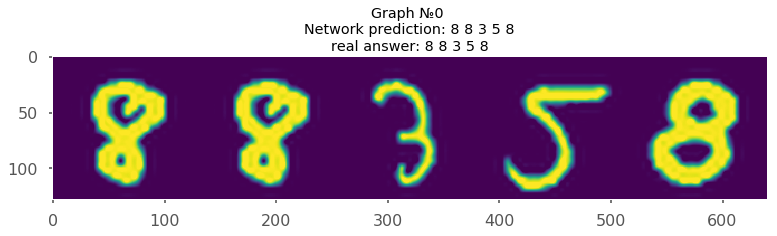

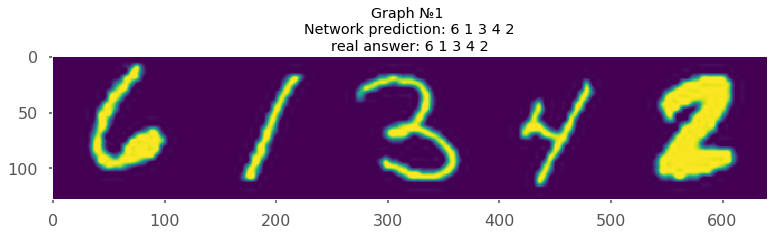

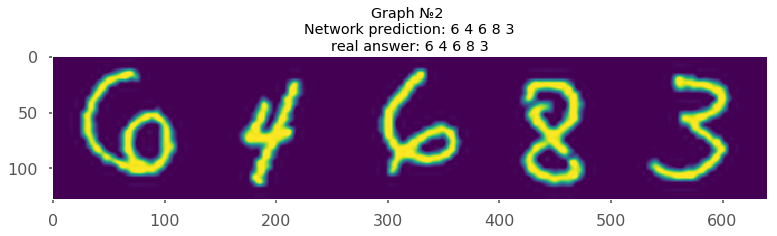

In [113]:
ind = np.random.choice(indx_true, 3)
draw(ind)

# Примеры с ошибками

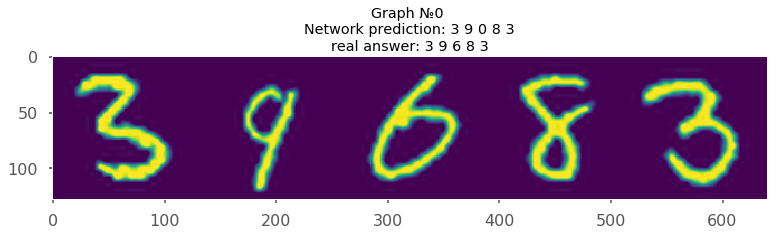

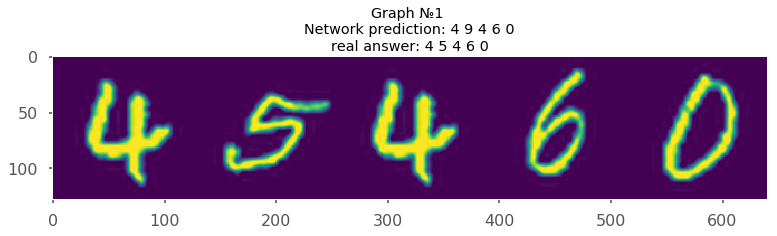

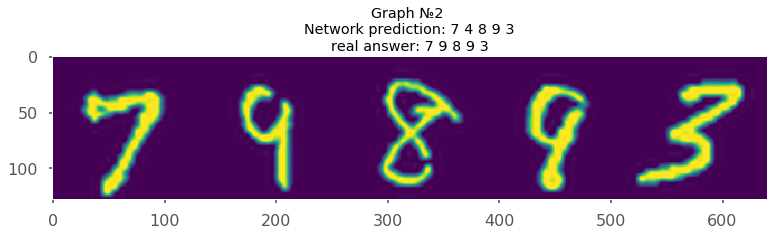

In [117]:
ind = np.random.choice(indx_false, 3)
draw(ind)